In [149]:
# -----------------------------------------
#   ----- ANALYSIS FOR PARTICIPANTS -----
# -----------------------------------------

# To choose between ;
#  a 3D space 
# a 5D space collapsed into 3D
# Do PCA power componant analysis

In [150]:
import pandas as pd
import numpy as np
import glob
import os
import pickle
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots

In [177]:
#Load CSV
DATA_DIR = "/Users/idilsu/Documents/Representations/Last/Data"

files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
print(f"Found {len(files)} participant files.")

all_df = []

for f in files:
    df = pd.read_csv(f)
    df["source_file"] = os.path.basename(f)
    all_df.append(df)

df = pd.concat(all_df, ignore_index=True)

# Clean column names
df = df.rename(columns=lambda c: c.strip().lower())

Found 25 participant files.


In [179]:
# DEMOGRAPHICS: gender counts & age

# One row per participant
df_demo = df[["participant", "age", "gender"]].drop_duplicates(subset="participant")

# Make sure age is numeric
df_demo["age"] = pd.to_numeric(df_demo["age"], errors="coerce")

print("\nNumber of unique participants:", len(df_demo))

# Gender counts
gender_counts = df_demo["gender"].value_counts(dropna=False)
print("\nGender counts:")
print(gender_counts)

# Age stats
mean_age = df_demo["age"].mean()
std_age = df_demo["age"].std()
min_age = df_demo["age"].min()
max_age = df_demo["age"].max()

print("\nAge statistics:")
print(f"Mean age: {mean_age:.2f}")
print(f"Age SD:   {std_age:.2f}")
print(f"Min age: {min_age:.2f}")
print(f"Max age: {max_age:.2f}")


Number of unique participants: 25

Gender counts:
gender
Female               17
Male                  7
Prefer not to say     1
Name: count, dtype: int64

Age statistics:
Mean age: 29.52
Age SD:   10.30
Min age: 22.00
Max age: 57.00


In [180]:
#keep only the similarity trials
df_sim = df[df["phase"] == "similarity"]

# Columns to  use:
#  left_skeleton 
#  right_skeleton 
#  rating (1–7 similarity)

df_sim = df_sim[["participant", "left_skeleton", "right_skeleton", "rating"]]


In [181]:
# Build list of unique actions

actions = sorted(set(df_sim["left_skeleton"]).union(df_sim["right_skeleton"]))
n = len(actions)
print("Number of actions:", n)
print("Actions:", actions)

Number of actions: 10
Actions: ['Cheer = 7', 'Clapping = 1', 'Cross_arms = 3', 'Hand_waving = 2', 'Pat_on_the back_or_comecome = 4', 'Salute = 5', 'Say_stop = 6', 'Stomp_or_step_on_foot = 8', 'Thumb_down = 9', 'Thumb_up = 10']


In [182]:
#Build RDM
# RDM of distances (distance = max - similarity)
RDM = pd.DataFrame(
    np.zeros((n, n)),
    index=actions,
    columns=actions
)

# we convert similarity ratings (1–7) into distances
MAX_SIM = df_sim["rating"].max()

for _, row in df_sim.iterrows():
    a = row["left_skeleton"]
    b = row["right_skeleton"]
    sim = row["rating"]
    dist = MAX_SIM - sim  # simple transform: higher = more different

    RDM.loc[a, b] += dist
    RDM.loc[b, a] += dist

# If multiple participants: average
# Because multiple participants contribute the same pair
counts = pd.DataFrame(
    np.zeros((n, n)),
    index=actions,
    columns=actions
)

for _, row in df_sim.iterrows():
    a = row["left_skeleton"]
    b = row["right_skeleton"]
    counts.loc[a, b] += 1
    counts.loc[b, a] += 1

RDM = RDM / counts.replace(0, np.nan)

# Fill diagonal
np.fill_diagonal(RDM.values, 0)

print("\nRDM built.")
print(RDM)



RDM built.
                                 Cheer = 7  Clapping = 1  Cross_arms = 3  \
Cheer = 7                             0.00          2.96            4.84   
Clapping = 1                          2.96          0.00            3.68   
Cross_arms = 3                        4.84          3.68            0.00   
Hand_waving = 2                       4.28          3.40            3.96   
Pat_on_the back_or_comecome = 4       4.24          4.60            4.72   
Salute = 5                            3.20          4.16            4.56   
Say_stop = 6                          1.84          3.08            3.48   
Stomp_or_step_on_foot = 8             5.20          5.24            4.24   
Thumb_down = 9                        4.88          4.64            4.28   
Thumb_up = 10                         4.48          4.52            4.88   

                                 Hand_waving = 2  \
Cheer = 7                                   4.28   
Clapping = 1                                3.4

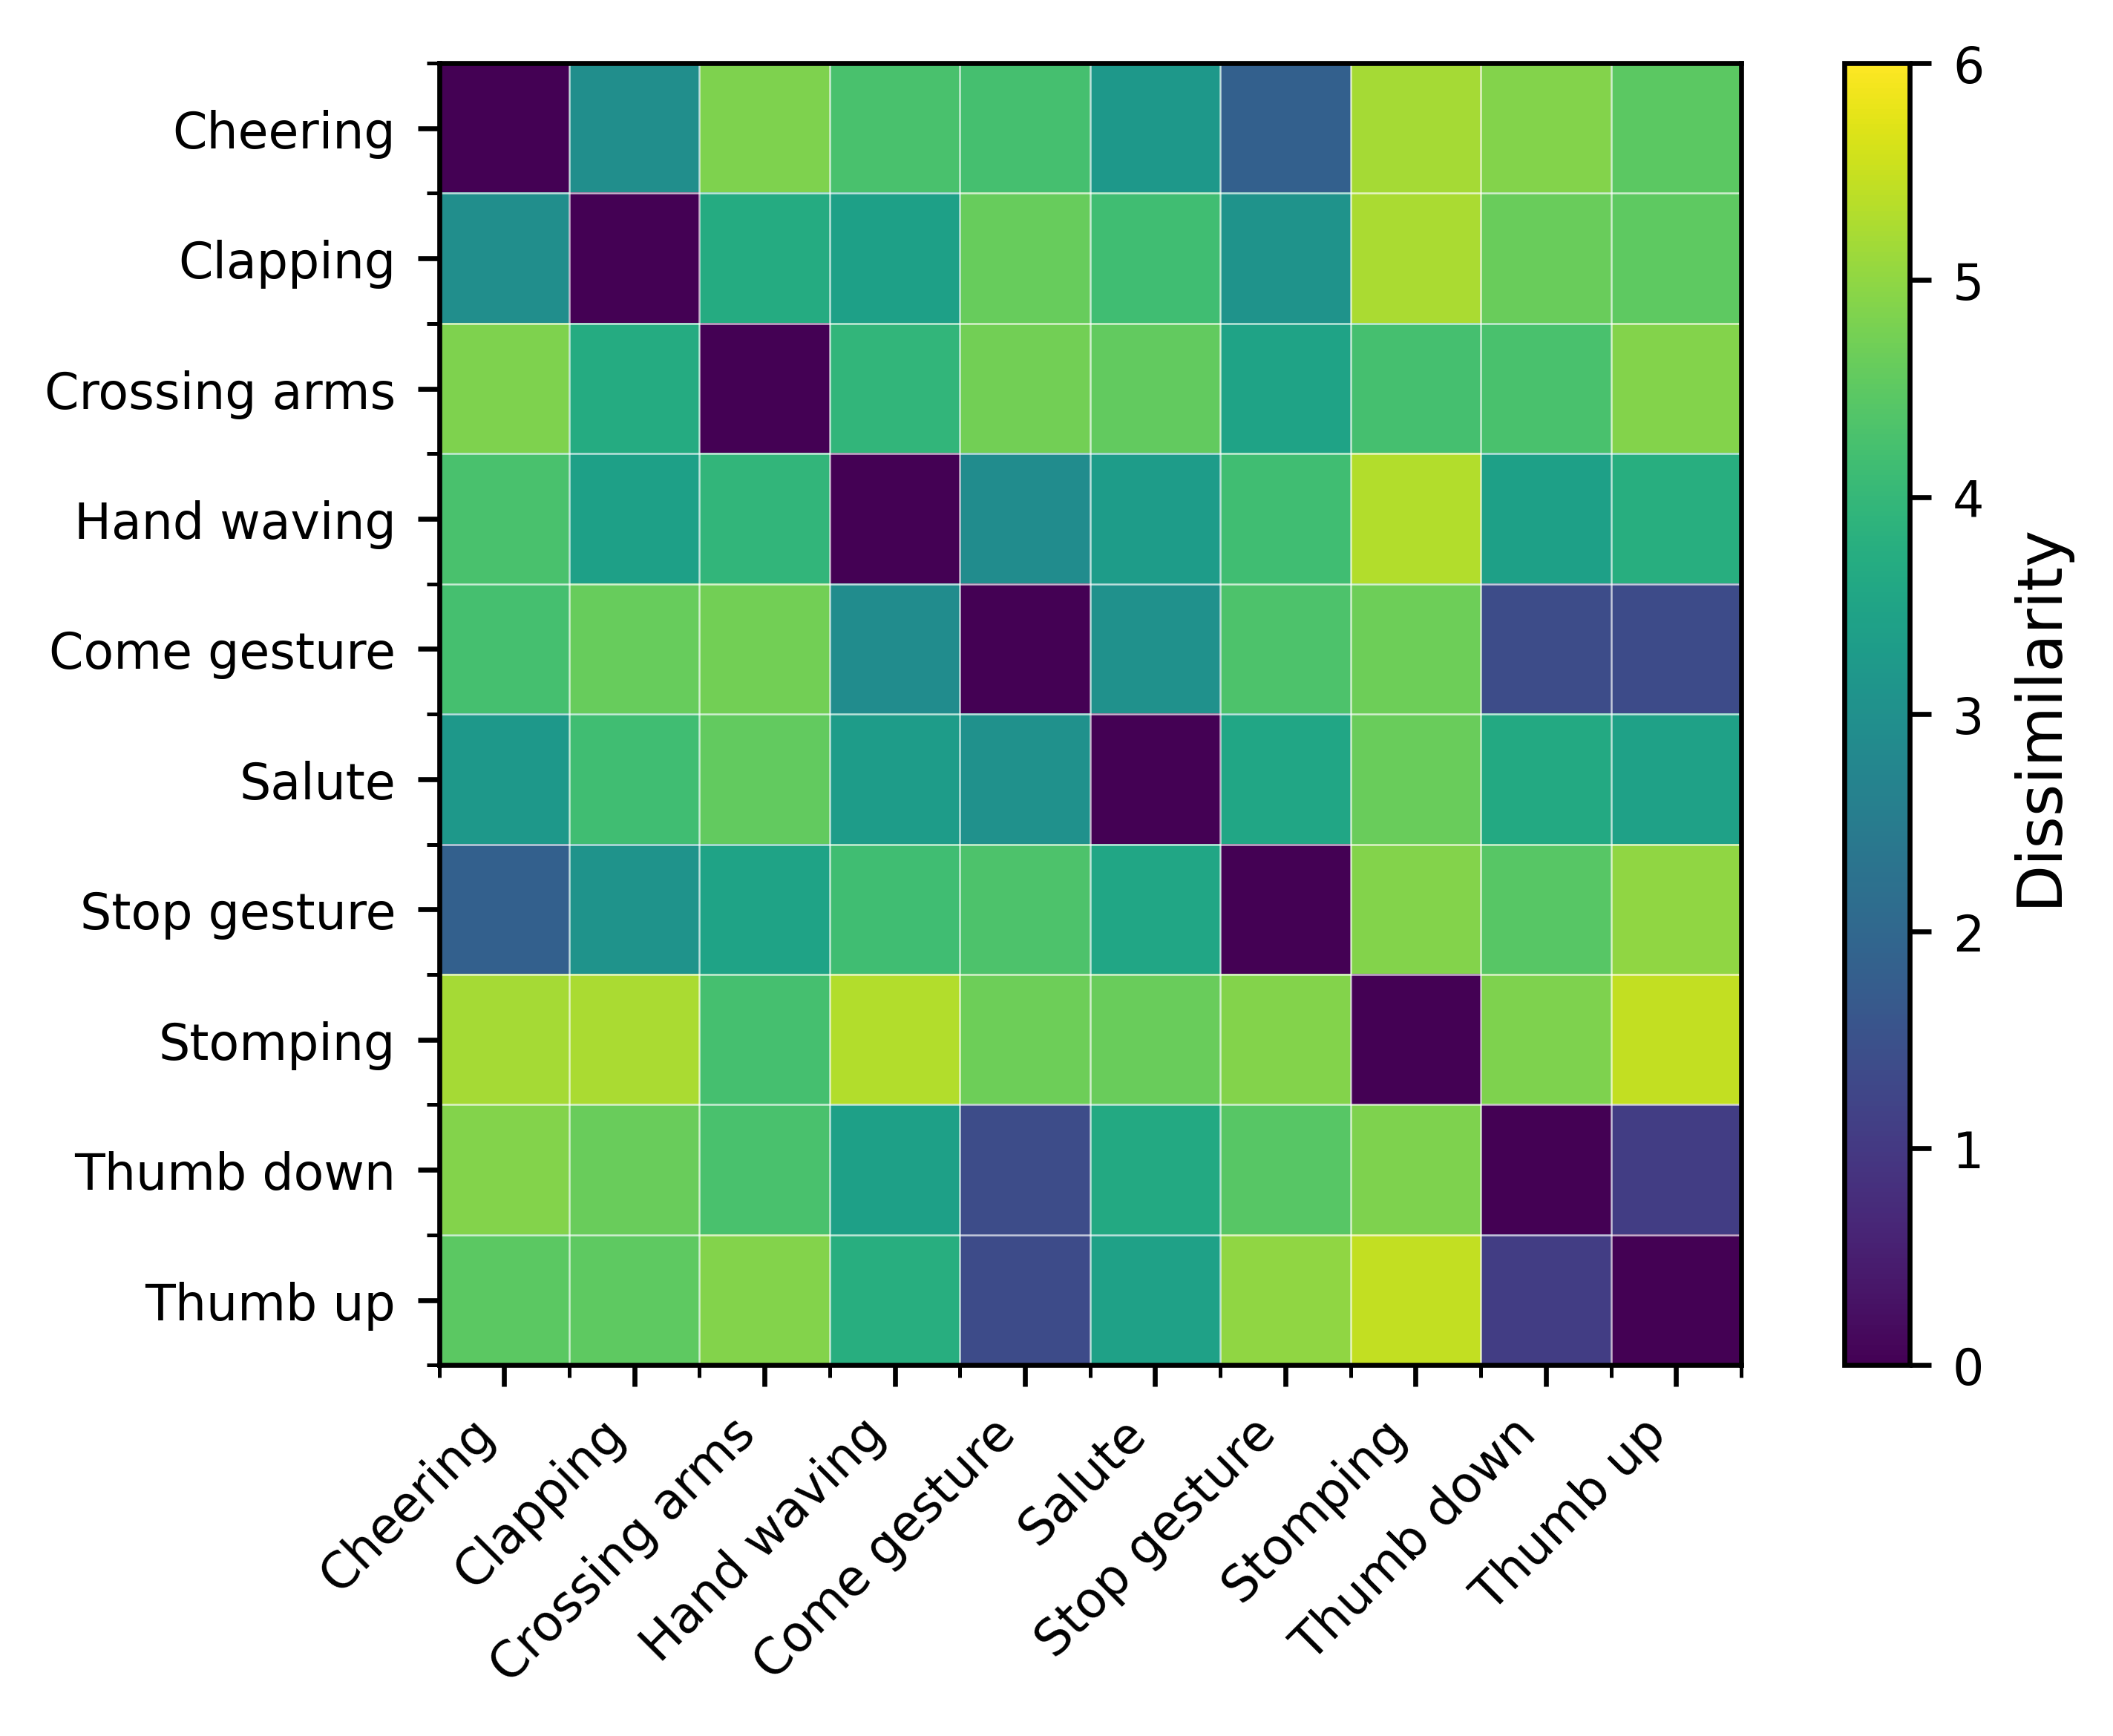

In [183]:
import numpy as np
import matplotlib.pyplot as plt

# Same short labels as for the movement RDM
pretty_actions = [
    "Cheering",
    "Clapping",
    "Crossing arms",
    "Hand waving",
    "Come gesture",
    "Salute",
    "Stop gesture",
    "Stomping",
    "Thumb down",
    "Thumb up",
]

# RDM is the group psychological RDM (pandas DataFrame or numpy array)
n = len(pretty_actions)  # or n = RDM.shape[0]

fig, ax = plt.subplots(figsize=(5, 4), dpi=600)

im = ax.imshow(
    RDM.values if hasattr(RDM, "values") else RDM,
    interpolation="nearest",
    cmap="viridis",
    vmin=0,
    vmax=6
)

ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(pretty_actions, rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(pretty_actions, fontsize=8)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.06)
cbar.set_label("Dissimilarity", fontsize=10)
cbar.ax.tick_params(labelsize=8)

ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=0.3, alpha=0.7)

ax.set_aspect("equal")

fig.tight_layout()
fig.savefig("psych_RDM_poster.png", dpi=600, bbox_inches="tight")
plt.show()

In [184]:
# 2D and 3D MDS fit
mds_2d = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
coords_2d = mds_2d.fit_transform(RDM.values)

mds_3d = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
coords_3d = mds_3d.fit_transform(RDM.values)

print("2D stress:", mds_2d.stress_)
print("3D stress:", mds_3d.stress_)

2D stress: 29.252044493633218
3D stress: 6.90938418836348


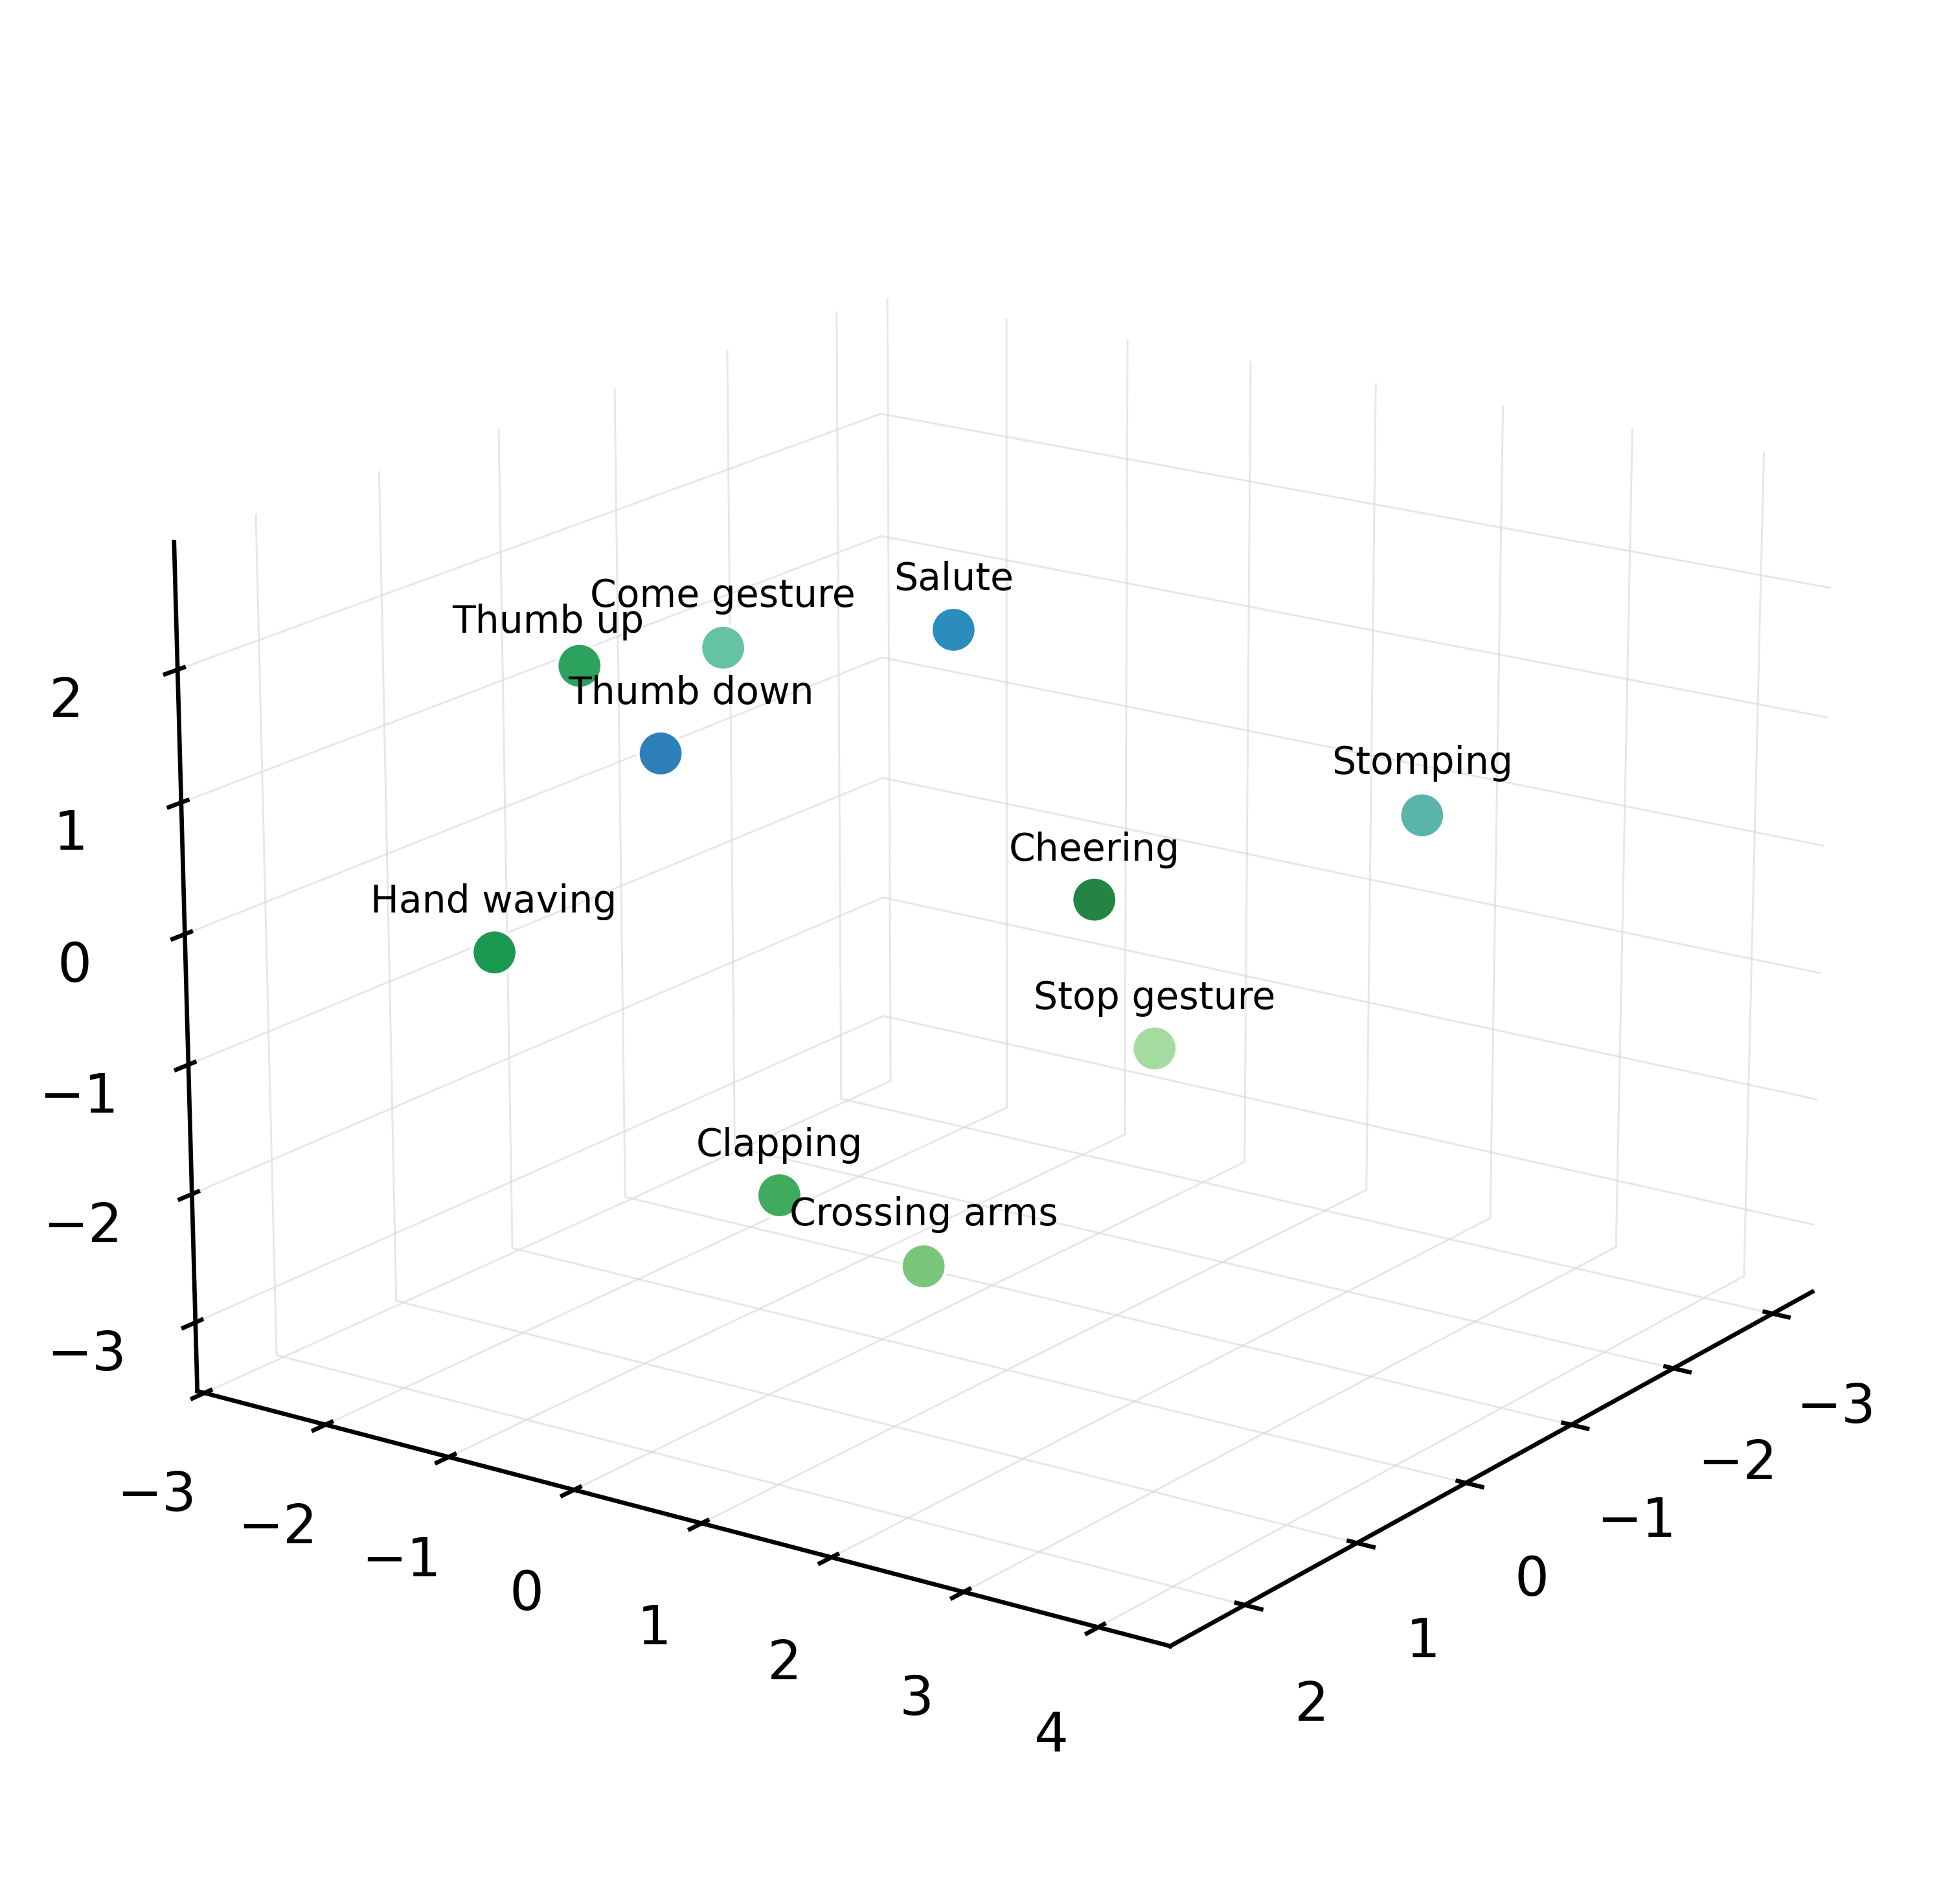

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Same labels & colours as movement MDS
pretty_actions = [
    "Cheering",
    "Clapping",
    "Crossing arms",
    "Hand waving",
    "Come gesture",
    "Salute",
    "Stop gesture",
    "Stomping",
    "Thumb down",
    "Thumb up",
]

green_teal_palette = [
    "#238443",  # Cheering      (deep green)
    "#41ab5d",  # Clapping
    "#78c679",  # Crossing arms
    "#1a9850",  # Hand waving
    "#66c2a5",  # Come gesture  (teal)
    "#2b8cbe",  # Salute        (blue-ish)
    "#a6dba0",  # Stop gesture
    "#5ab4ac",  # Stomping      (teal)
    "#2c7fb8",  # Thumb down    (blue)
    "#2ca25f",  # Thumb up      (strong green)
]
colors = np.array(green_teal_palette)

# --------- use psychological MDS coords here ---------
coords_plot_psych = coords_3d.copy()

# tiny nudges for thumbs so circles + labels don’t overlap
#coords_plot_psych[8, 0] -= 0.12   # Thumb down slightly left
#coords_plot_psych[9, 0] += 0.12   # Thumb up slightly right

fig = plt.figure(figsize=(6, 5), dpi=600)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    coords_plot_psych[:, 0],
    coords_plot_psych[:, 1],
    coords_plot_psych[:, 2],
    s=70,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    depthshade=False
)

# --------- labels (same style as movement MDS) ---------
dz = 0.25

for i, label in enumerate(pretty_actions):
    lx = coords_plot_psych[i, 0]
    ly = coords_plot_psych[i, 1]
    lz = coords_plot_psych[i, 2] + dz

    if label == "Thumb down":
        lx -= 0.20
        ly += 0.05
    elif label == "Thumb up":
        lx += 0.20
        ly -= 0.05

    ax.text(lx, ly, lz, label,
            fontsize=7, ha="center", va="bottom")

# axes & style: same camera, clean panes, light grid
#ax.set_xlabel("Dim 1", fontsize=9)
#ax.set_ylabel("Dim 2", fontsize=9)
#ax.set_zlabel("Dim 3", fontsize=9)
#ax.set_title("Psychological Space — 3D MDS", fontsize=11, pad=10)

ax.view_init(elev=18, azim=35)

ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)

for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo['grid']['linewidth'] = 0.35
    axis._axinfo['grid']['color'] = (0.85, 0.85, 0.85, 0.65)

margin = 0.9
ax.set_xlim(coords_plot_psych[:,0].min()-margin,
            coords_plot_psych[:,0].max()+margin)
ax.set_ylim(coords_plot_psych[:,1].min()-margin,
            coords_plot_psych[:,1].max()+margin)
ax.set_zlim(coords_plot_psych[:,2].min()-margin,
            coords_plot_psych[:,2].max()+margin)

fig.tight_layout()
fig.savefig("psych_MDS3D_poster.png", dpi=600, bbox_inches="tight")
plt.show()

Meaning the representation is at least 3D. There is a substantial decrease between 2D and 3D

1D stress: 186.4016
2D stress: 29.252044493633218
3D stress: 6.90938418836348
4D stress: 2.266054858416963
5D stress: 0.9047025723932325
6D stress: 0.42983247833012367


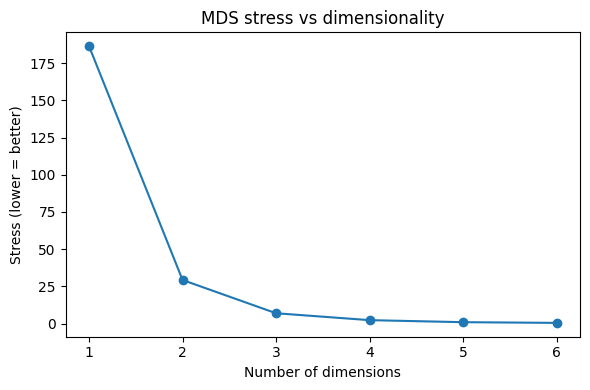

1D → 2D: 84.3% improvement
2D → 3D: 76.4% improvement
3D → 4D: 67.2% improvement
4D → 5D: 60.1% improvement
5D → 6D: 52.5% improvement


In [186]:
#Fit calculation 2D - 3D - 4D - ...

dims = range(1, 7)   # test 1D,2D,3D,4D,5D,6D
stresses = []

for d in dims:
    mds_d = MDS(
        n_components=d,
        dissimilarity="precomputed",
        random_state=1
    )
    mds_d.fit(RDM.values)
    stresses.append(mds_d.stress_)
    print(f"{d}D stress: {mds_d.stress_}")

# Plot stress vs dimension
plt.figure(figsize=(6,4))
plt.plot(dims, stresses, marker="o")
plt.xlabel("Number of dimensions")
plt.ylabel("Stress (lower = better)")
plt.title("MDS stress vs dimensionality")
plt.xticks(dims)
plt.tight_layout()
plt.show()

# Also print relative improvement from (d-1) to d
for i in range(1, len(dims)):
    prev = stresses[i-1]
    curr = stresses[i]
    improvement = (prev - curr) / prev
    print(f"{dims[i-1]}D → {dims[i]}D: {improvement*100:.1f}% improvement")

In [187]:
# Per participant RDM's 

participants = df_sim["participant"].unique()

rdm_per_subj = {}

for subj in participants:
    # Filter data for this subject
    df_sub = df_sim[df_sim["participant"] == subj]

    # Init empty RDM + counts
    RDM_sub = pd.DataFrame(
        np.zeros((n, n)),
        index=actions,
        columns=actions
    )
    counts_sub = pd.DataFrame(
        np.zeros((n, n)),
        index=actions,
        columns=actions
    )

    # Fill the RDM
    for _, row in df_sub.iterrows():
        a = row["left_skeleton"]
        b = row["right_skeleton"]
        sim = row["rating"]
        dist = MAX_SIM - sim  # convert similarity→distance

        RDM_sub.loc[a, b] += dist
        RDM_sub.loc[b, a] += dist
        counts_sub.loc[a, b] += 1
        counts_sub.loc[b, a] += 1

    # Average per pair
    RDM_sub = RDM_sub / counts_sub.replace(0, np.nan)
    np.fill_diagonal(RDM_sub.values, 0)

    # Save it
    rdm_per_subj[subj] = RDM_sub

print("Built per-subject RDMs for:", participants)

Built per-subject RDMs for: ['Semra Yenidoğan' 'Genco' 'Zeynep Kuvent' 'Defne Yagmur Senel' 'Lisa'
 'Medine' 'Diana' 'Leia' 'Yunus Başhasanoglu' 'Simge' 'Uğur Tırmıkçı'
 'Pırıl' 'Derin' 'asli' 'Defne Baturalp' 'Hatice Ertural' 'Ege Akçasoy'
 'Mira' 'Irmak' 'tolga' 'Elisa' 'Karen' 'Emre T' 'berra' 'yasemin']


In [188]:
# Noise ceiling 

# Collect per-subject RDMs into a list in the same order
subjects = list(rdm_per_subj.keys())
n_sub = len(subjects)

# Convert matrices to vectors (upper triangle only)
def rdm_to_vector(rdm):
    idx = np.triu_indices(len(rdm), k=1)
    return rdm.values[idx]

noise_correlations = []

for i, subj in enumerate(subjects):
    rdm_i = rdm_per_subj[subj]

    # Build leave-one-out group RDM
    others = [rdm_per_subj[s] for s in subjects if s != subj]
    group_without_i = sum(others) / (len(others))

    # Vectorize both
    v_i = rdm_to_vector(rdm_i)
    v_group = rdm_to_vector(group_without_i)

    # Spearman correlation
    corr, _ = spearmanr(v_i, v_group)
    noise_correlations.append(corr)

# Final noise ceiling = mean pairwise reliability
noise_ceiling = np.mean(noise_correlations)
noise_std = np.std(noise_correlations)

print("Noise ceiling (mean reliability):", noise_ceiling)
print("Noise ceiling std:", noise_std)

Noise ceiling (mean reliability): 0.5222881473437557
Noise ceiling std: 0.19401075501410547


In [189]:
# Save the data to use in correlation and pro analysis

# Convert per-subject RDMs to plain numpy arrays (to make them easier to save)
rdm_per_subj_np = {
    subj: rdm_per_subj[subj].values
    for subj in rdm_per_subj
}

save_dict = {
    "actions": actions,                 # list of action labels (order matters)
    "group_RDM": RDM.values,           # numpy array (n x n)
    "group_RDM_index": RDM.index.tolist(),  # redundant with actions, but safe
    "per_subject_RDMs": rdm_per_subj_np,    # dict: subj -> (n x n) array
    "subjects": list(rdm_per_subj.keys()),
    "coords_2d": coords_2d,            # (n x 2) MDS solution
    "coords_3d": coords_3d,            # (n x 3) MDS solution
    "noise_ceiling_mean": noise_ceiling,
    "noise_ceiling_std": noise_std
}

OUT_FILE = "/Users/idilsu/Documents/Representations/Last/psych_RDMs_and_MDS.pkl"

os.makedirs(os.path.dirname(OUT_FILE), exist_ok=True)

with open(OUT_FILE, "wb") as f:
    pickle.dump(save_dict, f)

print(f"\nSaved psychological RDMs and MDS to: {OUT_FILE}")


Saved psychological RDMs and MDS to: /Users/idilsu/Documents/Representations/Last/psych_RDMs_and_MDS.pkl
